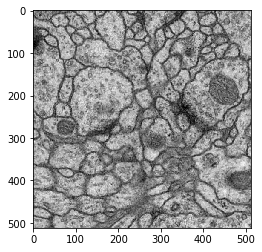

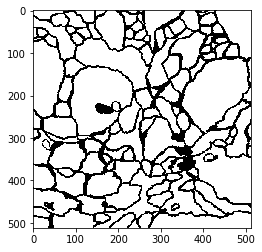

In [3]:
from torch.utils.data import DataLoader, Dataset
import PIL
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from albumentations import Compose
from albumentations import *
from torchvision import transforms
%matplotlib inline


neuron_target = './train-labels.tif'
neuron_train = './train-volume.tif'

im_stack_train = io.imread(neuron_train)
im_stack_test = io.imread(neuron_target)
plt.figure()
plt.imshow(im_stack_train[0], cmap='gray')
plt.figure()
plt.imshow(im_stack_test[0], cmap='gray')

# 1. Create a jupyter widget to explore the image stack (slide trough the stack).
# 2. Visualize the train and target on one image (transparent mask)
# 3. Implement NeuronSegmDataset
# 4. Use albumentations as the augmenter

In [42]:
# 1.
import ipywidgets as widgets
from ipywidgets import interact

def show_im_stack_train(slider_value):
    plt.figure()
    plt.imshow(im_stack_train[slider_value], cmap='gray')
    
interact(show_im_stack_train, 
         slider_value = widgets.IntSlider(value = 0, min = 0, max = len(im_stack_train) - 1, step = 1))

interactive(children=(IntSlider(value=0, description='slider_value', max=29), Output()), _dom_classes=('widget…

<function __main__.show_im_stack_train(slider_value)>

In [46]:
# 1.
import ipywidgets as widgets
from ipywidgets import interact

def show_im_stack_train(slider_value):
    plt.figure()
    plt.imshow(im_stack_test[slider_value], cmap='gray', alpha = 0.5)
    plt.imshow(im_stack_train[slider_value], cmap='gray', alpha = 0.5)
    
interact(show_im_stack_train, slider_value = widgets.IntSlider(value = 0, min = 0, max = len(im_stack_train) - 1, step = 1))

interactive(children=(IntSlider(value=0, description='slider_value', max=29), Output()), _dom_classes=('widget…

<function __main__.show_im_stack_train(slider_value)>

In [56]:

class NeuronSegmDataset(Dataset):
    def __init__(self, neuron_train_path, neuron_target_path, image_transform=None, augmenter=None):
        self.target_image = io.imread(neuron_train_path)
        self.target = io.imread(neuron_target_path)
        self.image_transform = image_transform
        self.augmenter = augmenter

    def __len__(self):
        return len(self.target)

    def __getitem__(self, ix):
        X = self.target_image[ix]
        y = self.target[ix]
        if self.augmenter:
            X, y = self.do_augment(X, y)
        if self.image_transform is not None:
            X = self.image_transform(X)
            y = self.image_transform(y)
        return X, y

    def _load_image(self, ix):
        # Load one slice from the stack as PIL.Image
        X = self.target_image[ix]
        return PIL.Image(X)
    def _load_target(self, ix):
        # Load one slice from mask as PIL.Image
        y = self.target[ix]
        return PIL.Image(y)

    def collate_func(self, batch):
        pass

    def do_augment(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        res = self.augmenter(image=X, mask=y)

        return PIL.Image.fromarray(res['image']), PIL.Image.fromarray(res['mask'])


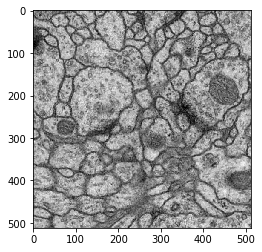

In [57]:

trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([RandomGamma(), 
               VerticalFlip(), 
               HorizontalFlip(),
               RandomRotate90(), 
               GridDistortion(),
               ElasticTransform(),
               OpticalDistortion(distort_limit=1, shift_limit=1)])


neuron_target = './train-labels.tif'
neuron_train = './train-volume.tif'

im_stack = io.imread(neuron_train)
plt.imshow(im_stack[0], cmap='gray')

train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)


In [59]:
X, y = train_ds[0]
assert X.shape == y.shape

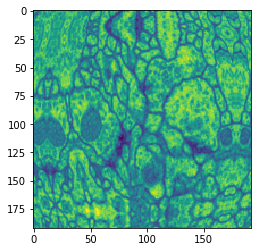

In [65]:
plt.imshow(X.squeeze())

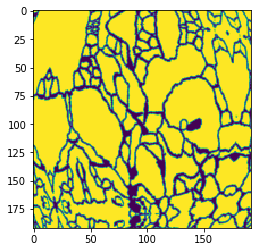

In [66]:
plt.imshow(y.squeeze())

In [67]:
X.shape

torch.Size([1, 192, 192])

In [81]:
# example: easier option to add multiple elements in widget
@interact
def visualize(ix=(0, len(im_stack_train)), show_mask=True):
    print(ix)
    pass

interactive(children=(IntSlider(value=15, description='ix', max=30), Checkbox(value=True, description='show_ma…

In [90]:
# example: easier option to add multiple elements in widget
@interact
def visualize(num_image=(0, len(im_stack_train) - 1), show_mask=True, alpha_mask = (0.0, 1.0), augment=True):
    plt.figure()
    alpha_image = 1 - alpha_mask
    X = im_stack_train[num_image]
    y = im_stack_test[num_image]
    if augment:
        X, y = train_ds[num_image]
        X = X.squeeze()
        y = y.squeeze()
    if show_mask:
        plt.imshow(y, cmap='gray', alpha = alpha_mask)
        plt.imshow(X, cmap='gray', alpha = alpha_image)
    else:
        plt.imshow(X, cmap='gray', alpha = 1.0)

interactive(children=(IntSlider(value=14, description='num_image', max=29), Checkbox(value=True, description='…